In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

### Read in Data Set

In [2]:
raw_data = pd.read_csv('household_power_consumption.txt', sep=';', na_values='?', index_col=0,
                       parse_dates=[[0,1]], infer_datetime_format=True, dayfirst=True)

In [3]:
raw_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
for i in range(raw_data.shape[1]):
    bad_cnt = raw_data.iloc[:, i].isnull().sum()
    print('Column %d has %d bad values.' % (i, bad_cnt))

Column 0 has 25979 bad values.
Column 1 has 25979 bad values.
Column 2 has 25979 bad values.
Column 3 has 25979 bad values.
Column 4 has 25979 bad values.
Column 5 has 25979 bad values.
Column 6 has 25979 bad values.


In [5]:
def FillAverageCurve(raw_data, full_row_outage=True, method='curve'):

    filled_data = raw_data.copy()
    if (full_row_outage):
        max_range = 1
    else:
        max_range = filled_data.shape[1]
    
    for col in range(max_range):
        last_row = -2

        null_series = filled_data.iloc[:, col].isnull()
        null_indices = np.where(null_series.values == True)[0].tolist()
        skip_cnt = 0
        for i in range(len(null_indices)):
            row = null_indices[i]

            if (last_row == row - 1):
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                continue

            if (i == len(null_indices) - 1):
                # This is the last null value in the column. The next row is good.
                filled_data.iloc[row] = (filled_data.iloc[row - 1] + filled_data.iloc[row + 1]) / 2
            else:
                good_idx = 0
                for k in range(i, len(null_indices)):
                    if (null_indices[k] != null_indices[k + 1] - 1):
                        good_idx = k
                        break
                    elif (k == len(null_indices) - 1):
                        good_idx = k
                next_good = filled_data.iloc[null_indices[good_idx] + 1]
                last_good = filled_data.iloc[row - 1]
                new_val = (last_good + next_good) / 2
                filled_data.iloc[row] = new_val
                if (method == 'curve'):
                    last_good = new_val
                last_row = row

        print('Column %d cleaned' % col)
    return filled_data

In [6]:
filled_data = FillAverageCurve(raw_data)#, method='flat')

Column 0 cleaned


In [11]:
# Add apparent power column
filled_data['Sub_metering_remainder'] = (filled_data['Global_active_power'] * 1000 / 60 - 
                                         filled_data['Sub_metering_1'] - filled_data['Sub_metering_2'] - 
                                         filled_data['Sub_metering_3'])

filled_data['Global_apparent_power'] = np.sqrt(filled_data['Global_active_power']**2 +
                                              filled_data['Global_reactive_power']**2)

### Load Temperature Data and Merge

In [48]:
temp_2006 = pd.read_csv('temp_2006.csv', sep=',') 
temp_2007 = pd.read_csv('temp_2007.csv', sep=',') 
temp_2008 = pd.read_csv('temp_2008.csv', sep=',') 
temp_2009 = pd.read_csv('temp_2009.csv', sep=',') 
temp_2010 = pd.read_csv('temp_2010.csv', sep=',') 
temp_data = pd.concat([temp_2006, temp_2007, temp_2008, temp_2009, temp_2010])
temp_datetime_data = pd.to_datetime( temp_data[['year','month','day']])
temps = pd.concat([temp_datetime_data, temp_data['temp']], axis=1)
temps.columns = ['Date_Time','temp']

In [49]:
temps.head()

,Date_Time,temp
0,2006-01-01,40.3
1,2006-01-02,39.1
2,2006-01-03,39.5
3,2006-01-04,36.0
4,2006-01-05,32.2


In [55]:

daily_data = filled_data.resample('D').agg({'Global_active_power': np.mean, 'Global_reactive_power': np.mean, 'Voltage': np.mean,
                                'Global_intensity': np.mean, 'Sub_metering_1': np.sum, 'Sub_metering_2': np.sum,
                                'Sub_metering_3': np.sum, 'Global_apparent_power': np.mean,
                                'Sub_metering_remainder': np.sum})
print(daily_data.shape)
daily_data.head()

(1442, 9)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_apparent_power,Sub_metering_remainder
Date_Time,,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,3.056187,14680.933333
2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,2.365602,36946.666667
2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,1.543069,19028.433333
2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,1.170682,13131.900000
2006-12-20,1.545658,0.111804,242.308063,6.467361,0.0,2648.0,14063.0,1.556785,20384.800000


In [57]:
merged_daily = pd.merge(daily_data, temps, on="Date_Time")
print(merged_daily.shape)
merged_daily.head()

(1442, 11)


,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_apparent_power,Sub_metering_remainder,temp
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.0,546.0,4926.0,3.056187,14680.933333,40.8
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,2.365602,36946.666667,37.7
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,1.543069,19028.433333,38.3
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,1.170682,13131.900000,35.7
4,2006-12-20,1.545658,0.111804,242.308063,6.467361,0.0,2648.0,14063.0,1.556785,20384.800000,36.4


# Here we can see that the temperature data from all of 2006 to 2010 in Paris, France has been merged onto the daily electrical data. It has been merged in such a way to only take the subset of the temperature data that matches to the existing dates on the electrical data

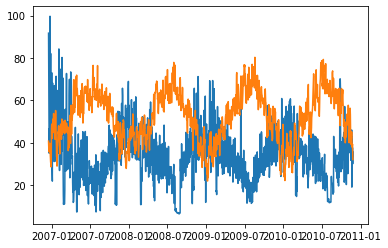

Correlation: -0.5238323593773616


In [152]:
power_temp_corr = merged_daily['Global_apparent_power'].corr(merged_daily['temp'])
plt.plot(merged_daily['Date_Time'], merged_daily['Global_apparent_power']*30)
plt.plot(merged_daily['Date_Time'], merged_daily['temp'])
plt.show()
print("Correlation: " + str(power_temp_corr))

# Here we can see that the temperature data is inversely correlated to power usage. As the weather gets very cold, people use more electricity; and as the weather gets nice, people use less electricity.

# Expanding on this idea, it is possible to develop a timeseries regession analysis to predict power usage based on weather predictions. For predicting timeseries, it is usually valuable to introduce delayed terms for leveraging trends over time. 

In [145]:
data_to_regress = pd.concat([merged_daily["Date_Time"], merged_daily["Global_apparent_power"], merged_daily["temp"]], axis=1)
data_to_regress.loc[:,'Yesterday_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift()
data_to_regress.loc[:,'Yesterday-1_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(1)
data_to_regress.loc[:,'Yesterday-2_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(2)
data_to_regress.loc[:,'Yesterday-3_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(3)
data_to_regress.loc[:,'Last_Week_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(7)

data_to_regress.loc[:,'Yesterday_Temp'] = data_to_regress.loc[:,"temp"].shift()
data_to_regress.loc[:,'Yesterday-1_Temp'] = data_to_regress.loc[:,"temp"].shift(1)
data_to_regress.loc[:,'Yesterday-2_Temp'] = data_to_regress.loc[:,"temp"].shift(2)
data_to_regress.loc[:,'Yesterday-3_Temp'] = data_to_regress.loc[:,"temp"].shift(3)
data_to_regress.loc[:,'Last_Week_Temp'] = data_to_regress.loc[:,"temp"].shift(7)

# dropping NAs
data_to_regress = data_to_regress.dropna()
data_to_regress.head()

,Date_Time,Global_apparent_power,temp,Yesterday_Power,Yesterday-1_Power,Yesterday-2_Power,Yesterday-3_Power,Last_Week_Power,Yesterday_Temp,Yesterday-1_Temp,Yesterday-2_Temp,Yesterday-3_Temp,Last_Week_Temp
7,2006-12-23,3.321892,35.4,1.641648,1.641648,1.203697,1.556785,3.056187,39.8,39.8,39.6,36.4,40.8
8,2006-12-24,1.779190,34.8,3.321892,3.321892,1.641648,1.203697,2.365602,35.4,35.4,39.8,39.6,37.7
9,2006-12-25,1.918893,33.0,1.779190,1.779190,3.321892,1.641648,1.543069,34.8,34.8,35.4,39.8,38.3
10,2006-12-26,2.736680,30.7,1.918893,1.918893,1.779190,3.321892,1.170682,33.0,33.0,34.8,35.4,35.7
11,2006-12-27,1.080604,31.0,2.736680,2.736680,1.918893,1.779190,1.556785,30.7,30.7,33.0,34.8,36.4


# For testing and training, we can test on the years 2006 to 2009 and test on the year 2010

In [146]:

mask1 = data_to_regress["Date_Time"] < np.datetime64('2010-01-01')
mask2 = data_to_regress["Date_Time"] >= np.datetime64('2010-01-01')

X_train = data_to_regress[mask1].drop(['Global_apparent_power'], axis = 1).drop(['Date_Time'], axis = 1)
y_train = data_to_regress[mask1]['Global_apparent_power']

X_test = data_to_regress[mask2].drop(['Global_apparent_power'], axis = 1).drop(['Date_Time'], axis = 1)
y_test = data_to_regress[mask2]['Global_apparent_power']


LR: 0.419789 (0.163218)


C:\AnacondaInstall\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\AnacondaInstall\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\AnacondaInstall\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LI

NN: 0.421937 (0.170302)
KNN: 0.043625 (0.209645)
RF: 0.233541 (0.172776)
SVR: 0.009032 (0.106026)


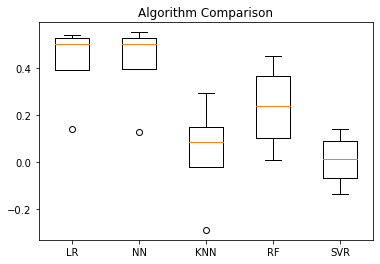

In [147]:
# code from: https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import sklearn.metrics as metrics
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=4)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [148]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [149]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(1,15)]
}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [150]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.4731
mean_squared_log_error:  0.0143
r2:  0.4701
MAE:  0.189
MSE:  0.0684
RMSE:  0.2615


# By tuning the hyperparameters in the Random Forest Regressor through a grid search algorithm we achieved a slightly better regession accuracy compared to using any of the default sklearn models.

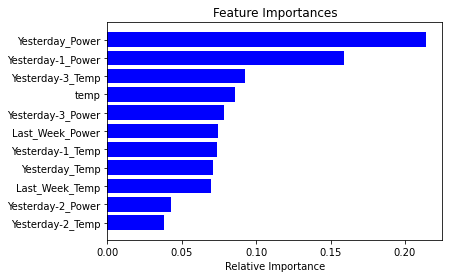

In [151]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()